# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2019

***
## 3. Variación de hiper-parámetros

> Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import matplotlib.pyplot as plt
import itertools
import gym
import numpy as np
from agents.utils.plotting import plot_reward_per_episode, plot_steps_per_episode, plot_steps_per_episode_smooth, draw_value_matrix

In [3]:
def choose_action(state):
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)

    if random_state.uniform() < epsilon:
        return random_state.choice(actions)  # a random action is selected

    count = q_values.count(max_q)

    # In case there're several state-action max values
    # we select a random one among them
    if count > 1:
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        i = q_values.index(max_q)

    return actions[i]

Definimos el método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo al algoritmo Q-Learning.

In [4]:
def learn(state, action, reward, next_state):
    """
    Performs a Q-Learning update for a given state transition
    """ 
    q_values = [q.get((next_state, a), 0.0) for a in actions]
    q[(state,action)] = q.get((state, action), 0.0) \
                        + alpha*(reward + gamma*max(q_values) - q.get((state, action), 0.0))    
    pass

Finalmente, definimos el método principal de iteraciones. 

In [5]:
def run():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        while not done:
            
            action = choose_action(state)
            
            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)


            episode_reward += reward

            if not done and t < max_steps:  # if the algorithm does not converge, it stops after 2000 timesteps
                learn(state, action, reward, next_state)
                state = next_state
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learn(state, action, reward, next_state)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

#### Definición de parámetros básicos

In [6]:
tau = 25

episodes_to_run = 500
max_steps = 2000

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

alpha_values = [0, 0.1, 0.5, 0.9, 1]
gamma_values = [0, 0.1, 0.5, 1]
epsilon_values = [0, 0.1, 0.5, 0.9, 1]

alpha_default = 0.5
gamma_default = 1
epsilon_default = 0.1

### 3.1 Variación de `alpha`

In [7]:
results = {'params' : [],
           'avg_steps_per_episode': [],
           'timesteps_ep': [],
           'reward_ep': [],
           'q': []
          }
for alpha in alpha_values:
    q = {}
    gamma = gamma_default
    epsilon = epsilon_default
    avg_steps_per_episode_i, timesteps_ep_i, reward_ep_i = run()
    results['params'].append('alpha_{}'.format(alpha))
    results['avg_steps_per_episode'].append(avg_steps_per_episode_i)
    results['timesteps_ep'].append(timesteps_ep_i)
    results['reward_ep'].append(reward_ep_i)
    results['q'].append(q)

### Análisis de la ejecución del agente

#### Recompensa acumulada por episodio
A continuación se muestra la recompensa por episodio (recordar que cada paso otorga una recompensa de $-1$ y caer al acantilado, una de $-100$)

Se puede observar que el desempeño del agente converge y muestra una tendencia a continuar disminuyendo, aunque al final lo hace en menor medida respecto a los primeros episodios. Cabe destacar que alrededor del episodio 100 hay un quiebre de comportamiento muy marcado.

alpha_0


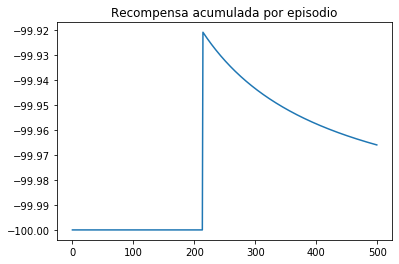

alpha_0.1


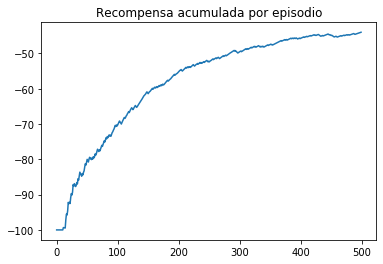

alpha_0.5


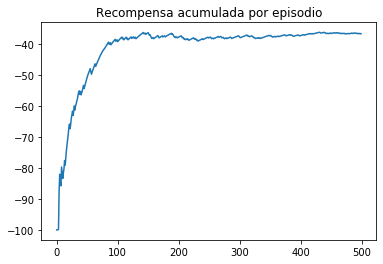

alpha_0.9


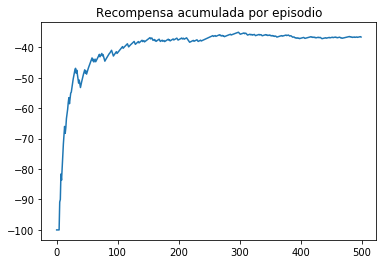

alpha_1


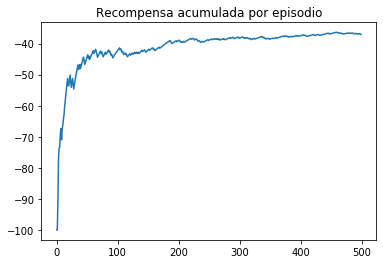

In [8]:
for i in range(len(alpha_values)):
    print(results['params'][i])
    plot_reward_per_episode(results['reward_ep'][i])

#### Pasos por episodio

A continuación se muestra la cantidad de pasos que le llevó al agente por cada episodio.

Al igual que con la recompensa, el desempeño del agente converge y muestra una cierta estabilidad hacia el final.

Se puede observar que la cantidad de pasos disminuye fuertemente en los primeros episodios y adquiere un poco de estabilidad alrededor del episodio 50. Además se observa un incremento del "ruido" en la gráfica alrededor del episodio 200.

alpha_0


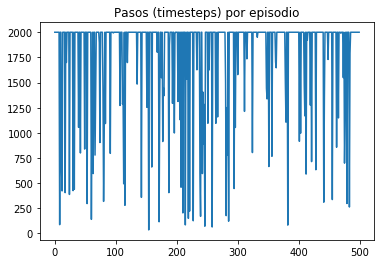

alpha_0.1


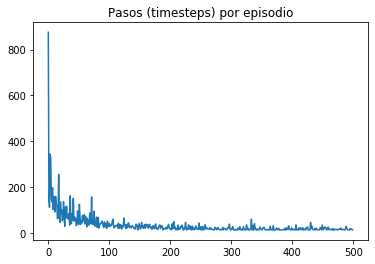

alpha_0.5


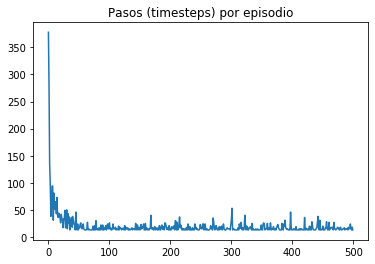

alpha_0.9


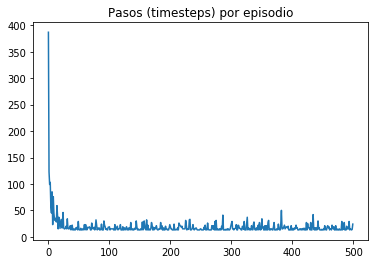

alpha_1


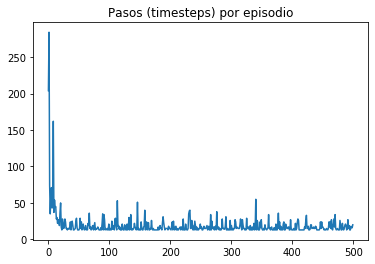

In [9]:
for i in range(len(alpha_values)):
    print(results['params'][i])
    plot_steps_per_episode(results['timesteps_ep'][i])

#### Pasos por episodio (Suavizados)

alpha_0


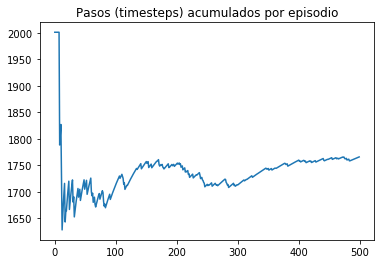

Cantidad de pasos mínima: 0

alpha_0.1


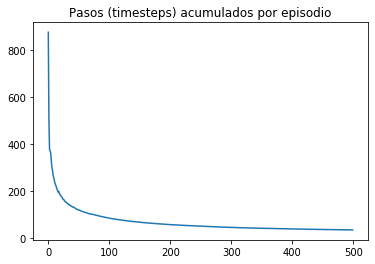

Cantidad de pasos mínima: .

alpha_0.5


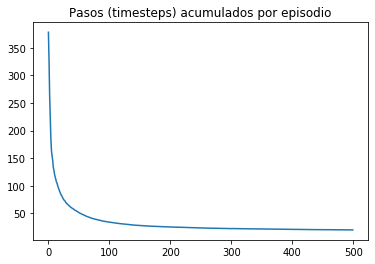

Cantidad de pasos mínima: .

alpha_0.9


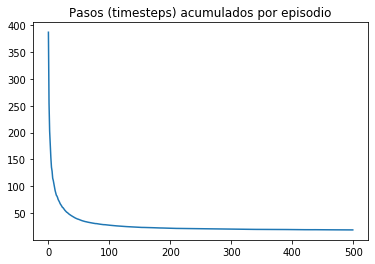

Cantidad de pasos mínima: .

alpha_1


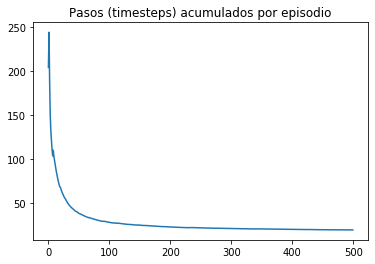

Cantidad de pasos mínima: 1



In [10]:
for i in range(len(alpha_values)):
    print(results['params'][i])
    plot_steps_per_episode_smooth(results['timesteps_ep'][i])
    print('Cantidad de pasos mínima: {}\n'.format(min(results['params'][i])))

### Matriz de acción-valor y política óptima

A continuación se puede observar desde otro punto de vista la convergencia alcanzada por el agente; es decir desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente.

En primera instancia se muestran los resultados obtenidos inicialmente (cuando no se implementó un algoritmo sino que era todo random). Luego se muestra la matriz que resulta de aplicar el algoritmo SARSA y se hace un análisis comparativo entre ellas.

alpha_0


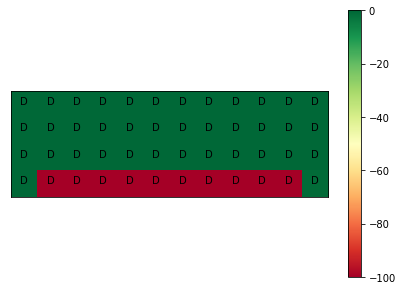


 Matriz de mejor acción-valor (en números): 

 [[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]
alpha_0.1


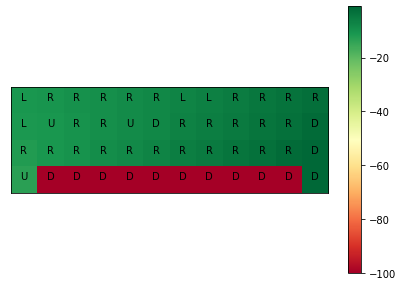


 Matriz de mejor acción-valor (en números): 

 [[ -10.95813477  -10.51787376   -9.8901669    -9.19745117   -8.43348747
    -7.65760936   -6.84942074   -6.07107647   -5.26101651   -4.45437594
    -3.66000078   -2.8992807 ]
 [ -11.37211584  -10.82237883  -10.09603951   -9.32756053   -8.51153913
    -7.65932671   -6.76590419   -5.83863239   -4.91029804   -3.95790736
    -2.98691425   -1.99986138]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]
alpha_0.5


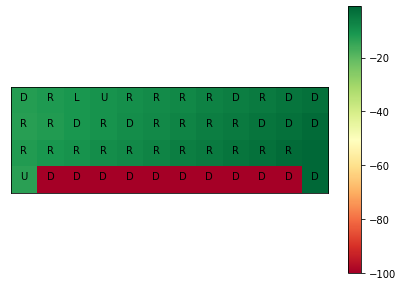


 Matriz de mejor acción-valor (en números): 

 [[ -12.46052237  -11.795605    -10.93288323  -10.09937982   -9.3477108
    -8.45043961   -7.5945642    -6.73164403   -5.839749     -4.9063153
    -3.94569687   -2.99672655]
 [ -12.94227031  -11.98043037  -10.99478467   -9.99890639   -8.99960751
    -7.99992547   -6.9999726    -5.99998773   -4.99999301   -3.99999874
    -2.99999974   -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]
alpha_0.9


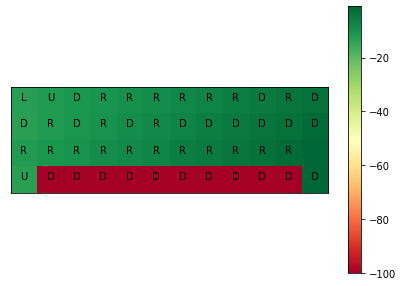


 Matriz de mejor acción-valor (en números): 

 [[ -12.92555591  -12.17234504  -11.27605424  -10.51666054   -9.52913852
    -8.81323845   -7.89204083   -6.90633423   -5.95595542   -4.98963606
    -3.99672792   -2.99999403]
 [ -12.9998333   -11.99999993  -10.99999999  -10.           -9.
    -8.           -7.           -6.           -5.           -4.
    -3.           -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]
alpha_1


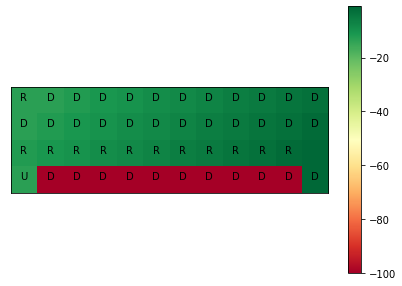


 Matriz de mejor acción-valor (en números): 

 [[ -13.  -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.]
 [ -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.]
 [ -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.   -1.]
 [ -13. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


In [11]:
for i in range(len(alpha_values)):
    print(results['params'][i])
    draw_value_matrix(results['q'][i])

In [12]:
env.close()

### 3.2 Variación de `epsilon`

Este es el factor de exploración, el cual indica la probabilidad de que el agente explore nuevas estrategias en lugar de explotar.

In [13]:
results = {'params' : [],
           'avg_steps_per_episode': [],
           'timesteps_ep': [],
           'reward_ep': [],
           'q': []
          }
for epsilon in epsilon_values:
    q = {}
    alpha = alpha_default
    gamma = gamma_default
    avg_steps_per_episode_i, timesteps_ep_i, reward_ep_i = run()
    results['params'].append('epsilon_{}'.format(epsilon))
    results['avg_steps_per_episode'].append(avg_steps_per_episode_i)
    results['timesteps_ep'].append(timesteps_ep_i)
    results['reward_ep'].append(reward_ep_i)
    results['q'].append(q)

### Análisis de la ejecución del agente

#### Recompensa acumulada por episodio
A continuación se muestra la recompensa por episodio (recordar que cada paso otorga una recompensa de $-1$ y caer al acantilado, una de $-100$)

Se puede observar que el desempeño del agente converge y muestra una tendencia a continuar disminuyendo, aunque al final lo hace en menor medida respecto a los primeros episodios. Cabe destacar que alrededor del episodio 100 hay un quiebre de comportamiento muy marcado.

epsilon_0


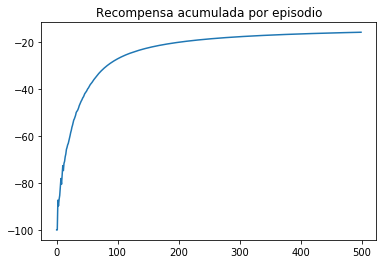

epsilon_0.1


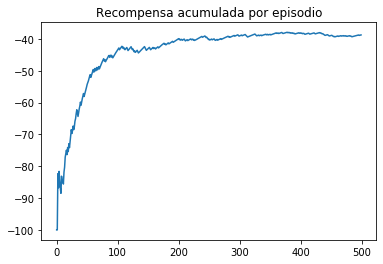

epsilon_0.5


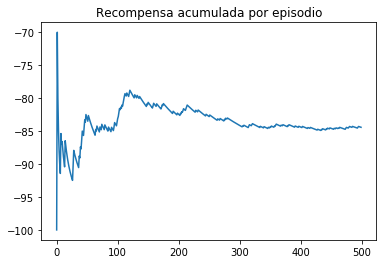

epsilon_0.9


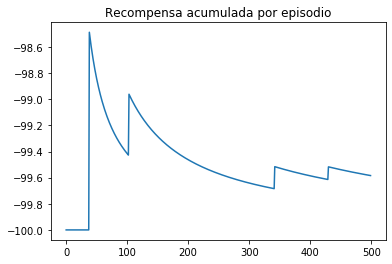

epsilon_1


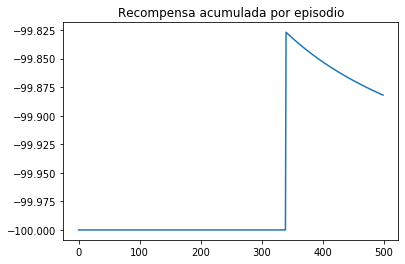

In [14]:
for i in range(len(epsilon_values)):
    print(results['params'][i])
    plot_reward_per_episode(results['reward_ep'][i])

#### Pasos por episodio

A continuación se muestra la cantidad de pasos que le llevó al agente por cada episodio.

Al igual que con la recompensa, el desempeño del agente converge y muestra una cierta estabilidad hacia el final.

Se puede observar que la cantidad de pasos disminuye fuertemente en los primeros episodios y adquiere un poco de estabilidad alrededor del episodio 50. Además se observa un incremento del "ruido" en la gráfica alrededor del episodio 200.

epsilon_0


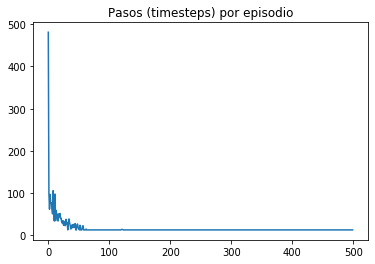

epsilon_0.1


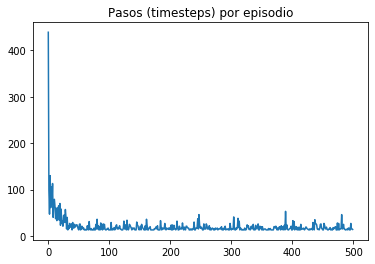

epsilon_0.5


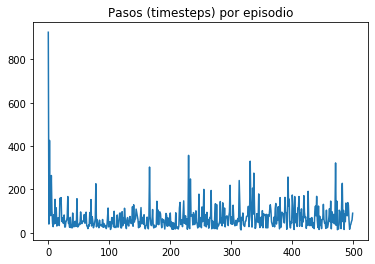

epsilon_0.9


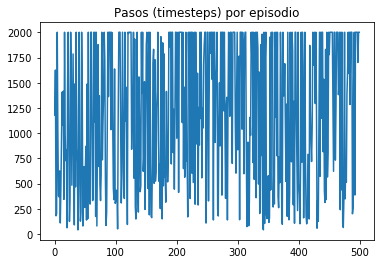

epsilon_1


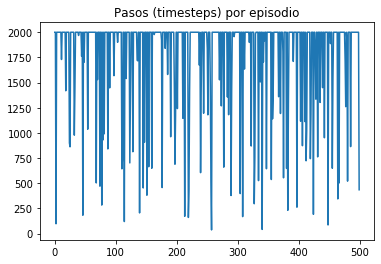

In [15]:
for i in range(len(epsilon_values)):
    print(results['params'][i])
    plot_steps_per_episode(results['timesteps_ep'][i])

#### Pasos por episodio (Suavizados)

epsilon_0


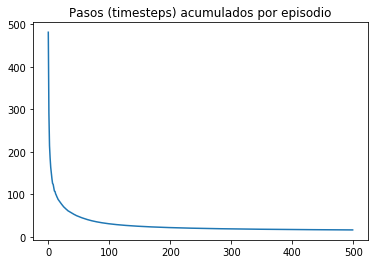

epsilon_0.1


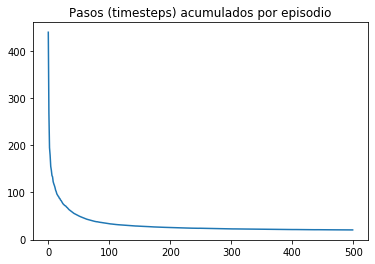

epsilon_0.5


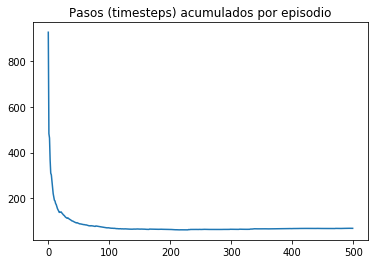

epsilon_0.9


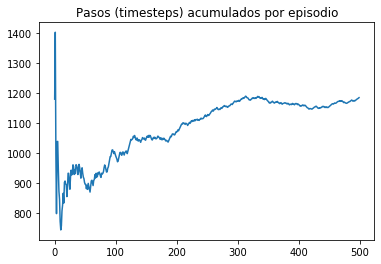

epsilon_1


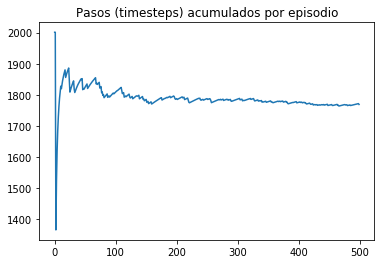

In [16]:
for i in range(len(epsilon_values)):
    print(results['params'][i])
    plot_steps_per_episode_smooth(results['timesteps_ep'][i])

### Matriz de acción-valor y política óptima

A continuación se puede observar desde otro punto de vista la convergencia alcanzada por el agente; es decir desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente.

En primera instancia se muestran los resultados obtenidos inicialmente (cuando no se implementó un algoritmo sino que era todo random). Luego se muestra la matriz que resulta de aplicar el algoritmo SARSA y se hace un análisis comparativo entre ellas.

epsilon_0


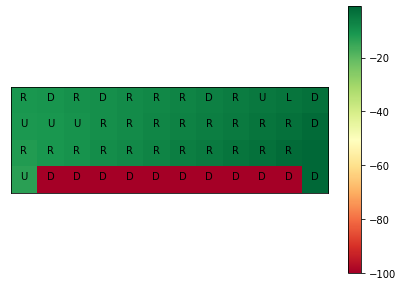


 Matriz de mejor acción-valor (en números): 

 [[ -10.96108743  -10.4354929    -9.82072409   -9.24690909   -8.47010278
    -7.67934367   -6.97169825   -6.12471175   -5.3367672    -4.5
    -3.74023438   -2.95209772]
 [ -11.29335816  -10.70240711   -9.95206272   -9.21063225   -8.38782823
    -7.53696794   -6.64082024   -5.76338457   -4.8900614    -3.93918476
    -2.98461088   -1.99981258]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]
epsilon_0.1


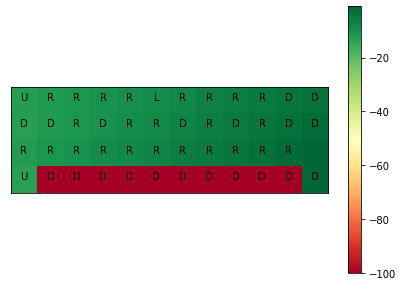


 Matriz de mejor acción-valor (en números): 

 [[ -12.46560669  -11.81372571  -10.94496331  -10.09370323   -9.25926422
    -8.38404647   -7.59305777   -6.67075924   -5.82987356   -4.89195365
    -3.97695175   -2.99953208]
 [ -12.93360291  -11.99222167  -10.996496     -9.99828222   -8.99958797
    -7.9998488    -6.99997423   -5.99999672   -4.99999841   -3.99999979
    -2.99999996   -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]
epsilon_0.5


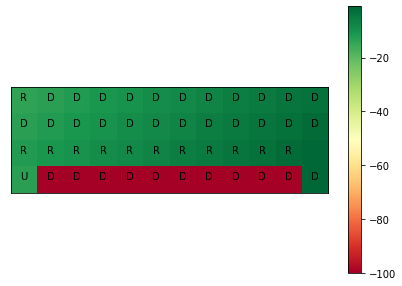


 Matriz de mejor acción-valor (en números): 

 [[ -14.  -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.]
 [ -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.]
 [ -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.   -1.]
 [ -13. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]
epsilon_0.9


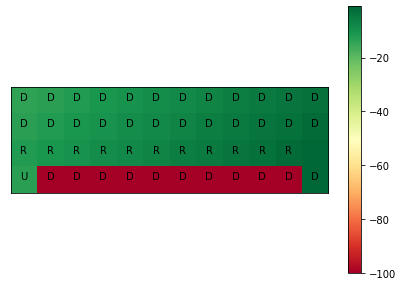


 Matriz de mejor acción-valor (en números): 

 [[ -14.  -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.]
 [ -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.]
 [ -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.   -1.]
 [ -13. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]
epsilon_1


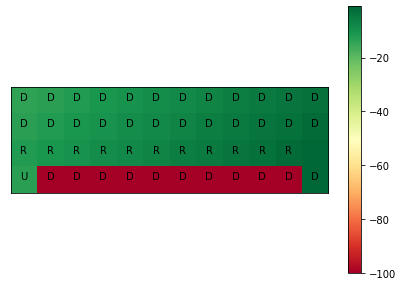


 Matriz de mejor acción-valor (en números): 

 [[ -14.  -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.]
 [ -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.]
 [ -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.   -1.]
 [ -13. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


In [17]:
for i in range(len(epsilon_values)):
    print(results['params'][i])
    draw_value_matrix(results['q'][i])

In [18]:
env.close()

### 3.3 Variación de `gamma`

Este parámetro es el factor de descuento que afecta a las recompensas futuras.

In [19]:
results = {'params' : [],
           'avg_steps_per_episode': [],
           'timesteps_ep': [],
           'reward_ep': [],
           'q': []
          }
for gamma in gamma_values:
    q = {}
    alpha = alpha_default
    epsilon = epsilon_default
    avg_steps_per_episode_i, timesteps_ep_i, reward_ep_i = run()
    results['params'].append('gamma_{}'.format(gamma))
    results['avg_steps_per_episode'].append(avg_steps_per_episode_i)
    results['timesteps_ep'].append(timesteps_ep_i)
    results['reward_ep'].append(reward_ep_i)
    results['q'].append(q)

### Análisis de la ejecución del agente

#### Recompensa acumulada por episodio
A continuación se muestra la recompensa por episodio ante la variación del parámetro `gamma`.

gamma_0


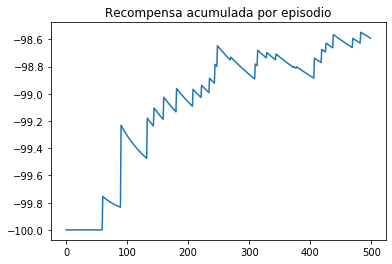

gamma_0.1


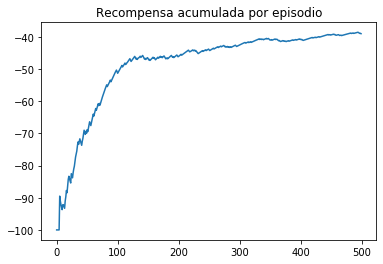

gamma_0.5


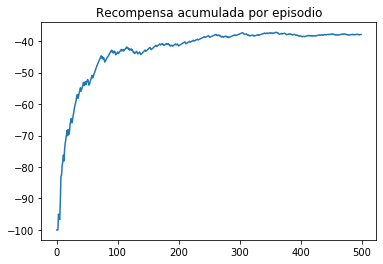

gamma_1


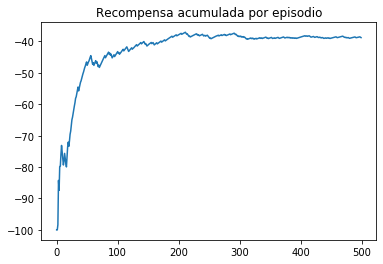

In [20]:
for i in range(len(gamma_values)):
    print(results['params'][i])
    plot_reward_per_episode(results['reward_ep'][i])

Dado que este factor afecta a las recompensas futuras y una falta del mismo (`gamma = 0`) implica que las decisiones se guían sólo por la recompensa actual de cada acción, es razonable observar que en `gamma = 0` el gráfico de recompensas se muestre inestable y con recompensas muy bajas. 

Por otra parte, a medida que el factor aumenta, considera más equitativamente a las recompensas futuras, lo cual se puede observar en la convergencia que tiene el gráfico de recompensas en los últimos episodios. 

De todas maneras, cabe destacar que para `gamma = 1` el gráfico se torna menos "suave" que para los valores anteriores, aunque conserva la forma y la convergencia.

#### Pasos por episodio

A continuación se muestra la cantidad de pasos que le llevó al agente por cada episodio ante los diferentes valores del parámetro `gamma`

gamma_0


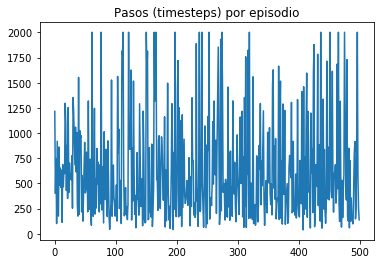

gamma_0.1


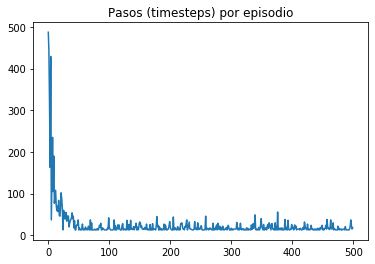

gamma_0.5


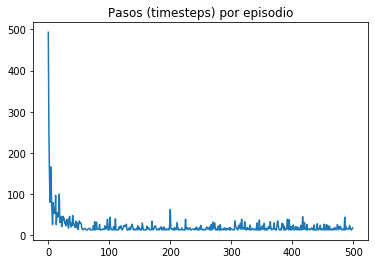

gamma_1


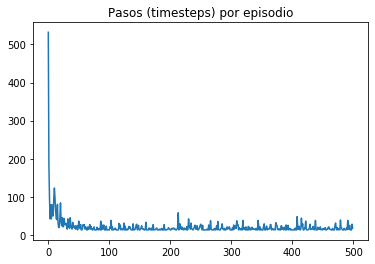

In [21]:
for i in range(len(gamma_values)):
    print(results['params'][i])
    plot_steps_per_episode(results['timesteps_ep'][i])

En los gráficos se puede notar la inestabilidad que genera tener un `gamma = 0` y el incremento de la cantidad de pasos respecto a todos los otros valores.

Los valores `0.1 <= gamma <= 1` muestran convergencia a partir del episodio 50, aunque con un leve nivel de "ruido".

#### Pasos por episodio (Suavizados)

gamma_0


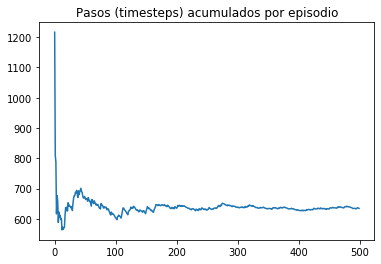

gamma_0.1


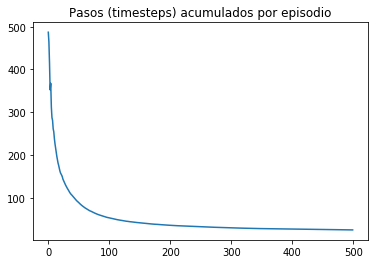

gamma_0.5


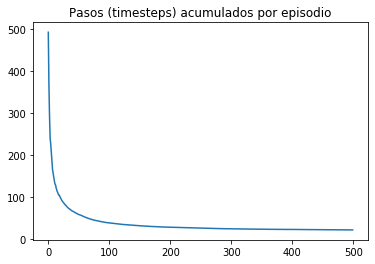

gamma_1


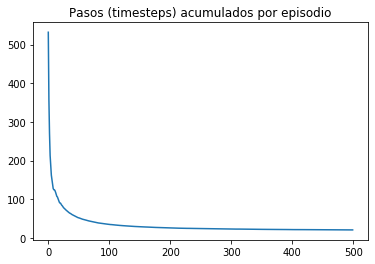

In [22]:
for i in range(len(gamma_values)):
    print(results['params'][i])
    plot_steps_per_episode_smooth(results['timesteps_ep'][i])

Si bien los gráficos anteriores están suavizados, el `gamma = 0` sigue mostrando inestabilidad respecto a los demás, en este caso es menor pero sí se puede notar.

Por otro lado, los casos de `0.1 <= gamma <= 1` muestran convergencia.

### Matriz de acción-valor y política óptima

A continuación se puede observar desde otro punto de vista la convergencia alcanzada por el agente; es decir desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente.


gamma_0


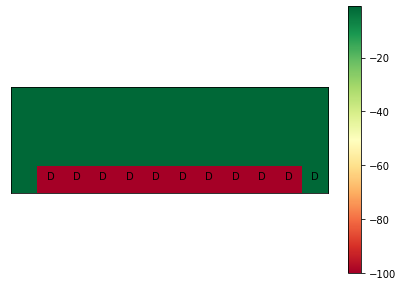


 Matriz de mejor acción-valor (en números): 

 [[  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]
gamma_0.1


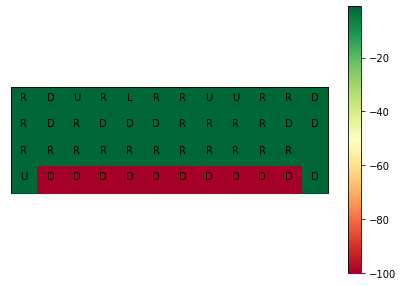


 Matriz de mejor acción-valor (en números): 

 [[  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.11111111
    -1.1111111    -1.11111106   -1.11111071   -1.1111085    -1.1110935
    -1.11097062   -1.10999265]
 [  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.11111111
    -1.1111111    -1.111111     -1.11111      -1.1111       -1.111
    -1.11         -1.1       ]
 [  -1.11111111   -1.11111111   -1.11111111   -1.11111111   -1.1111111
    -1.111111     -1.11111      -1.1111       -1.111        -1.11
    -1.1          -1.        ]
 [  -1.11111111 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]
gamma_0.5


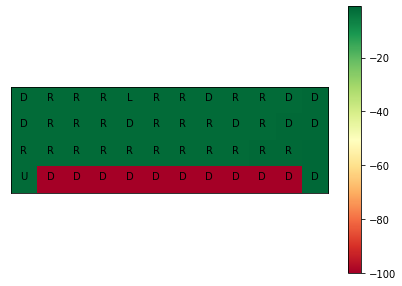


 Matriz de mejor acción-valor (en números): 

 [[  -1.99961958   -1.99940428   -1.99899053   -1.99817745   -1.99673095
    -1.99430584   -1.98958599   -1.98011972   -1.96295792   -1.9319792
    -1.87366368   -1.74987603]
 [  -1.99974823   -1.99950736   -1.99902095   -1.99804568   -1.99609302
    -1.99218715   -1.98437465   -1.96874987   -1.93749994   -1.87499998
    -1.75         -1.5       ]
 [  -1.99951172   -1.99902344   -1.99804688   -1.99609375   -1.9921875
    -1.984375     -1.96875      -1.9375       -1.875        -1.75
    -1.5          -1.        ]
 [  -1.99975586 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]
gamma_1


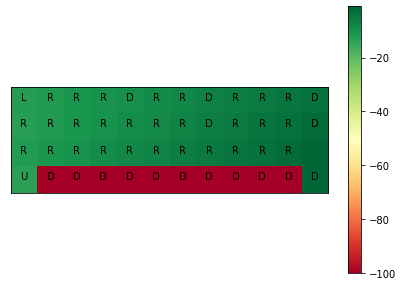


 Matriz de mejor acción-valor (en números): 

 [[ -12.375       -11.76998168  -11.0086058   -10.20930862   -9.29144295
    -8.56523103   -7.69473172   -6.79189353   -5.8880312    -4.95571969
    -3.98254094   -2.99895786]
 [ -12.94295317  -11.9974734   -10.99884343   -9.99966569   -8.99983672
    -7.99993438   -6.99996761   -5.99998831   -4.99999717   -3.99999979
    -2.99999999   -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [23]:
for i in range(len(gamma_values)):
    print(results['params'][i])
    draw_value_matrix(results['q'][i])

En las matrices se puede observar que para `gamma = 0` no hay mejor acción para la mayoría de los estados, lo cual podría asociarse a que no se consideran las recompensas futuras y por lo tanto no recibe señales de que alguna de las acciones dispinibles (L, R, D, U) es la mejor.

Por otro lado, a medida que aumenta gamma, los valores de los estados para las mejores acciones va disminuyendo. En `gamma = 0.5` se observa el mejor rendimiento.

In [24]:
env.close()